# CIFAR Classification

CIFAR10 is a new dataset that is harder to classify. It contains 50000 training images and 10000 validation images. The objects are more complex and varied (different types of birds, automobiles, frogs, horses, etc.). Contains 32x32 colored images! 

### Lesson 1: Testing LeNeT

Load the CIFAR10 dataset

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#CIFAR 10 images are 32x32 
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#need to divide images into batches
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)

##validation loader
validation_loader =  torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def im_convert(tensor):
    #cannot convert cuda tensor to numpy. need cpa
    #so if using cuda use:
    # image = tensor.cpu().clone().detach().numpy()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [5]:
#making a classes collection type
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

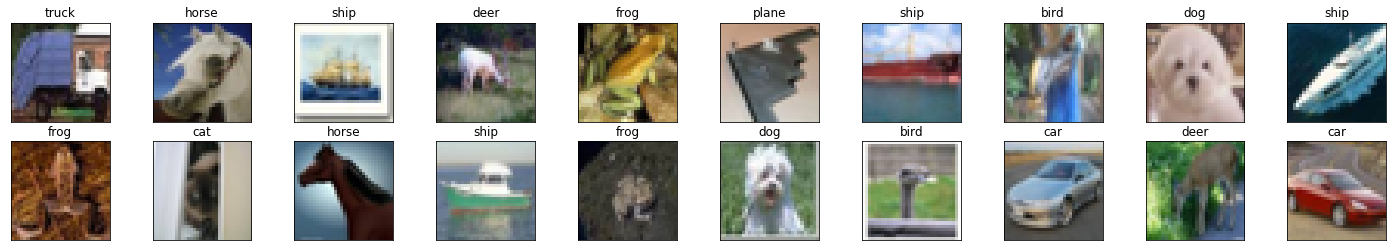

In [6]:
#shows which class each image belongs in and we see how complex it is
dataiter = iter(training_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [7]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #define a convolutional layer
        self.conv1 = nn.Conv2d(3, 20, 5, 1) #difference here is that we'll have 3 input layers because RGB
        #before we only had grayscale so only had 1 before
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #define the fully connected layers
        self.fc1 = nn.Linear(5*5*50, 500) 
        self.fc2 = nn.Linear(500, 10) #output because 10 classes
    
    #define the pooling and activation functions
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        #second conv layer
        x = F.relu(self.conv2(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        #reshape x, need to flatten so it can go into FC layer
        x = x.view(-1, 5*5*50) #columns (decided automatically), rows
        #attach relu to first FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #no activation funciton here because going to use nn Cross entropy loss
        return x 

In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) 

In [10]:
#specifiy number of epochs
epochs = 15
#want to analyze loss after each epoch so need to graph
running_loss_history = []
running_corrects_history = [] #store accruacy at each epoch

##validation part
val_running_loss_history = []
val_running_corrects_history = []

#iterate through each epoch
for e in range(epochs):
    #need to go through each training batch provided by training loader
    running_loss = 0.0
    running_corrects = 0.0
    
    ##after training, we iterate through validation set to test our data
    #measure performance to check for overfitting 
    ##validation
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) #call the forward function to get raw final score
        #output is compared to actual labels
        loss = criterion(outputs, labels) #compare and determine error based on cross entropy criterion
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) #first value is max score that was made by the model
        running_loss += loss.item() #append the current loss at the batch iteration to the loss list
        #want to compare the prediction to the actual label to see how many got correct
        #second value will be top predictions
        running_corrects += torch.sum(preds == labels.data) #every element of both tensors, compare the prediction to the actual class label
        #if comparision matches, then will place a value of one
    
    
    else:
        with torch.no_grad(): #set all requires grad flags to be false
        ##validation
            for val_inputs, val_labels in validation_loader: 
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #make predictions and calculate loss for validation
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
        epoch_loss = running_loss/len(training_loader) #get the average loss at the epoch
        epoch_acc = running_corrects.float()/ len(training_loader) #average accuracy at that epoch
        #now append
        running_loss_history.append(epoch_loss) #observe decrease in loss at every epoch
        running_corrects_history.append(epoch_acc)
        
        ##same for validation
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch :', (e+1)) #because epoch starts at 0
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7627, acc 37.0400
validation loss: 1.5264, validation acc 45.1200
epoch : 2
training loss: 1.4552, acc 48.3260
validation loss: 1.3849, validation acc 50.8600
epoch : 3
training loss: 1.3562, acc 51.9600
validation loss: 1.3130, validation acc 53.4720
epoch : 4
training loss: 1.2830, acc 54.7000
validation loss: 1.2371, validation acc 56.5040
epoch : 5
training loss: 1.2181, acc 57.3000
validation loss: 1.1735, validation acc 59.0360
epoch : 6
training loss: 1.1641, acc 59.1940
validation loss: 1.1212, validation acc 60.8480
epoch : 7
training loss: 1.1160, acc 61.1900
validation loss: 1.1048, validation acc 60.8400
epoch : 8
training loss: 1.0752, acc 62.5380
validation loss: 1.0488, validation acc 63.5700
epoch : 9
training loss: 1.0410, acc 63.9000
validation loss: 1.0082, validation acc 64.9640
epoch : 10
training loss: 1.0087, acc 65.0340
validation loss: 0.9737, validation acc 66.2160
epoch : 11
training loss: 0.9779, acc 66.1120
validation loss: 0.9519

The accuracy is low and the loss is overall pretty high still. Almost runs risk of overfitting around 6 epochs.

Recall, overfitting is when the validation is trailing behind the training. 

The accuracy is clearly not optimal. 

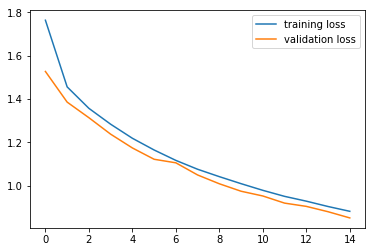

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

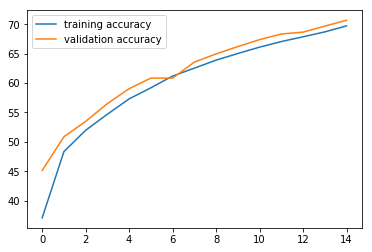

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

Taking a look at images from the web to get a visual perspective of the model accuracy. 

<Response [200]>


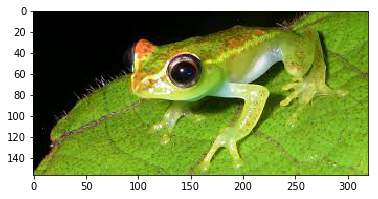

In [13]:
import requests #to grab an image
from PIL import Image #python imaging library
import PIL.ImageOps
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcToWuV6vpSa3VkBCti_nCF_SPylwqSb6kSS0w&usqp=CAU'
#url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKRracnqXM4xEcQxsnPkj1adJiklwj0tmv1w&usqp=CAU'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
print(response) #successful get request

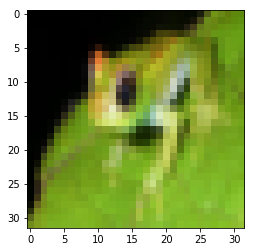

In [14]:
img = transform(img) #transforms and get a more abstracted 32x32 representation
plt.imshow(im_convert(img))

In [15]:
image = img.to(device).unsqueeze(0)
#The unsqueeze is to account for the extra layer of dimensionality
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


LOL. Thinks the frog is incorrect. Which is expected from a poorly trained model. So let's take a look at the predictions of a subset of the validation set. 

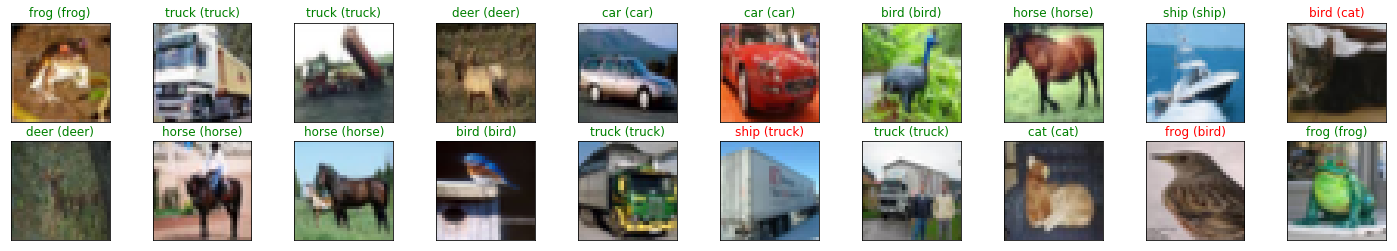

In [16]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))


Model is somewhat able to generalize, but clearly labels 3 of the images incorrectly. 

### Lesson 2: Hyperparameter turning

How can we fine tune the network to provide better performance? Well the accuracy is only ~69% (not high enough). Modifications are case dependent and fine tuning is a specific process and unique for each deep learning task. But overall is important to always modify to see how modifications improve the effectivness of the model. 
1. Change the learning rates
    - Remember Adam optimizer computed individual adaptive learning rates
    - if LR too high = lower accuracy. 
    - if LR too small = significantly slow down training rate. But in our clase the training process doesn't seem too slow because the accuracy improves decently from each epoch. If it doesn't, then the learning rate is too small. 
2. Increase depth (adding another layer to network)
    - Common architecture is that each layer doubles the depth and output of the preceeding layer. 
3. Different kernel size 
    - Overfitting can benefit from a smaller kernel size too. Larger kernel implies more parameters at a higher level expressive power but risk overfitting. 
    - WHen in doubt, always helpful to try different kernels. We used 5 so far...what if we used 3? 
    - Also can make use of padding to preserve the edge pixels and max feature extraction 

##### 1. Change the learning rate

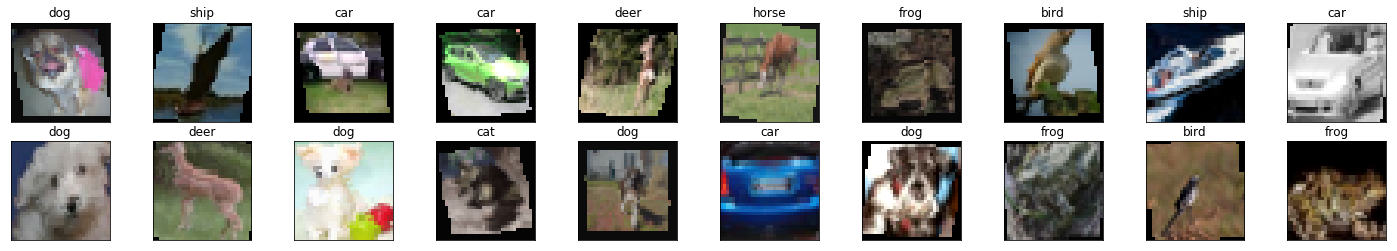

In [28]:
dataiter = iter(training_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [29]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #define a convolutional layer
        self.conv1 = nn.Conv2d(3, 20, 5, 1) #difference here is that we'll have 3 input layers because RGB
        #before we only had grayscale so only had 1 before
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        #define the fully connected layers
        self.fc1 = nn.Linear(5*5*50, 500) 
        self.fc2 = nn.Linear(500, 10) #output because 10 classes
    
    #define the pooling and activation functions
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        #second conv layer
        x = F.relu(self.conv2(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        #reshape x, need to flatten so it can go into FC layer
        x = x.view(-1, 5*5*50) #columns (decided automatically), rows
        #attach relu to first FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #no activation funciton here because going to use nn Cross entropy loss
        return x 

In [30]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 

In [32]:
#specifiy number of epochs
epochs = 15
#want to analyze loss after each epoch so need to graph
running_loss_history = []
running_corrects_history = [] #store accruacy at each epoch

##validation part
val_running_loss_history = []
val_running_corrects_history = []

#iterate through each epoch
for e in range(epochs):
    #need to go through each training batch provided by training loader
    running_loss = 0.0
    running_corrects = 0.0
    
    ##after training, we iterate through validation set to test our data
    #measure performance to check for overfitting 
    ##validation
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) #call the forward function to get raw final score
        #output is compared to actual labels
        loss = criterion(outputs, labels) #compare and determine error based on cross entropy criterion
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) #first value is max score that was made by the model
        running_loss += loss.item() #append the current loss at the batch iteration to the loss list
        #want to compare the prediction to the actual label to see how many got correct
        #second value will be top predictions
        running_corrects += torch.sum(preds == labels.data) #every element of both tensors, compare the prediction to the actual class label
        #if comparision matches, then will place a value of one
    
    
    else:
        with torch.no_grad(): #set all requires grad flags to be false
        ##validation
            for val_inputs, val_labels in validation_loader: 
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #make predictions and calculate loss for validation
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
        epoch_loss = running_loss/len(training_loader) #get the average loss at the epoch
        epoch_acc = running_corrects.float()/ len(training_loader) #average accuracy at that epoch
        #now append
        running_loss_history.append(epoch_loss) #observe decrease in loss at every epoch
        running_corrects_history.append(epoch_acc)
        
        ##same for validation
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch :', (e+1)) #because epoch starts at 0
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.5561, acc 43.7740
validation loss: 1.2472, validation acc 54.9200
epoch : 2
training loss: 1.2419, acc 55.8980
validation loss: 1.0775, validation acc 61.8500
epoch : 3
training loss: 1.1076, acc 60.8340
validation loss: 1.0236, validation acc 64.2200
epoch : 4
training loss: 1.0279, acc 63.9240
validation loss: 0.9130, validation acc 68.2200
epoch : 5
training loss: 0.9593, acc 66.2760
validation loss: 0.8814, validation acc 68.9700
epoch : 6
training loss: 0.9157, acc 68.0420
validation loss: 0.8676, validation acc 70.0200
epoch : 7
training loss: 0.8748, acc 69.1880
validation loss: 0.8210, validation acc 71.1800
epoch : 8
training loss: 0.8346, acc 70.8420
validation loss: 0.8087, validation acc 72.2400
epoch : 9
training loss: 0.8112, acc 71.8500
validation loss: 0.7671, validation acc 73.5900
epoch : 10
training loss: 0.7824, acc 72.7180
validation loss: 0.7675, validation acc 73.3000
epoch : 11
training loss: 0.7554, acc 73.5740
validation loss: 0.7599

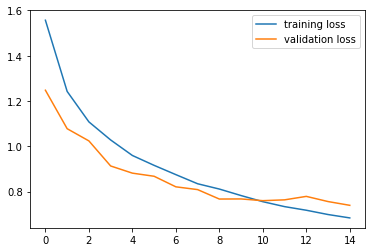

In [33]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

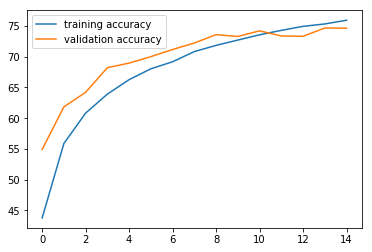

In [34]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

Now in the case of a larger learning rate of 0.001, we do get higher accuracy! But it does look like right at 15 epochs, we do start to get over fitting (when the validation loss is higher than the training loss). 

Useful to see how a small modification can affect the accuracy.

Now what we can also do is add one more layer to the network. 

##### 2. Increase Depth and 3. Change kernel size

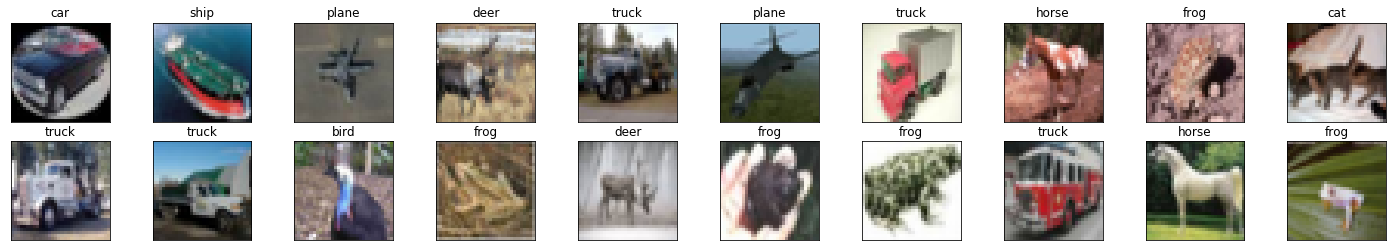

In [44]:
dataiter = iter(training_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [45]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #define a convolutional layer
        #depth of conv1 is assigned as 16, doubling the layer gives 32
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)  # change kernel from 5 to 3 and added padding here to max edge feature extraction
        #doubling the conv1 (16) gives 32
        #this means the depth of the output is consistently increased going from one layer to the next
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        #deeper the layers, the more the network will extract more features
        
        #adding another convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        #define the fully connected layers
        self.fc1 = nn.Linear(4*4*64, 500) 
        self.fc2 = nn.Linear(500, 10) #output because 10 classes
    
    #define the pooling and activation functions
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        #second conv layer
        x = F.relu(self.conv2(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        
        #applying the relu function to the 3rd layer! 
        #third conv layer
        x = F.relu(self.conv3(x)) #added depth will help extract more features effectively and improve accuracy. 
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        
        #reshape x, need to flatten so it can go into FC layer
        x = x.view(-1, 4*4*64) #THIS DEPENDS ON KERNEL SIZE...DOUBLE CHECK THIS. 
        #attach relu to first FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #no activation funciton here because going to use nn Cross entropy loss
        return x 

In [46]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 

In [48]:
#specifiy number of epochs
epochs = 15
#want to analyze loss after each epoch so need to graph
running_loss_history = []
running_corrects_history = [] #store accruacy at each epoch

##validation part
val_running_loss_history = []
val_running_corrects_history = []

#iterate through each epoch
for e in range(epochs):
    #need to go through each training batch provided by training loader
    running_loss = 0.0
    running_corrects = 0.0
    
    ##after training, we iterate through validation set to test our data
    #measure performance to check for overfitting 
    ##validation
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) #call the forward function to get raw final score
        #output is compared to actual labels
        loss = criterion(outputs, labels) #compare and determine error based on cross entropy criterion
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) #first value is max score that was made by the model
        running_loss += loss.item() #append the current loss at the batch iteration to the loss list
        #want to compare the prediction to the actual label to see how many got correct
        #second value will be top predictions
        running_corrects += torch.sum(preds == labels.data) #every element of both tensors, compare the prediction to the actual class label
        #if comparision matches, then will place a value of one
    
    
    else:
        with torch.no_grad(): #set all requires grad flags to be false
        ##validation
            for val_inputs, val_labels in validation_loader: 
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #make predictions and calculate loss for validation
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
        epoch_loss = running_loss/len(training_loader) #get the average loss at the epoch
        epoch_acc = running_corrects.float()/ len(training_loader) #average accuracy at that epoch
        #now append
        running_loss_history.append(epoch_loss) #observe decrease in loss at every epoch
        running_corrects_history.append(epoch_acc)
        
        ##same for validation
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch :', (e+1)) #because epoch starts at 0
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.4982, acc 45.2780
validation loss: 1.1681, validation acc 58.5140
epoch : 2
training loss: 1.0991, acc 60.7060
validation loss: 0.9600, validation acc 66.3040
epoch : 3
training loss: 0.9249, acc 67.2740
validation loss: 0.8364, validation acc 71.0740
epoch : 4
training loss: 0.8104, acc 71.5080
validation loss: 0.7397, validation acc 73.9920
epoch : 5
training loss: 0.7164, acc 74.7940
validation loss: 0.6411, validation acc 77.5000
epoch : 6
training loss: 0.6339, acc 78.0460
validation loss: 0.5525, validation acc 80.7980
epoch : 7
training loss: 0.5589, acc 80.4400
validation loss: 0.4706, validation acc 83.8780
epoch : 8
training loss: 0.4858, acc 82.9440
validation loss: 0.3743, validation acc 87.6240
epoch : 9
training loss: 0.4177, acc 85.3820
validation loss: 0.3307, validation acc 88.8780
epoch : 10
training loss: 0.3519, acc 87.6120
validation loss: 0.2861, validation acc 90.2880
epoch : 11
training loss: 0.2880, acc 89.9600
validation loss: 0.2286

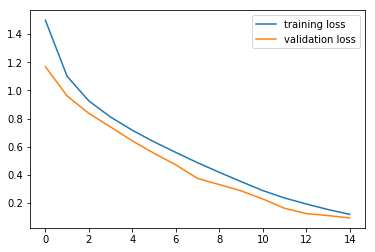

In [49]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

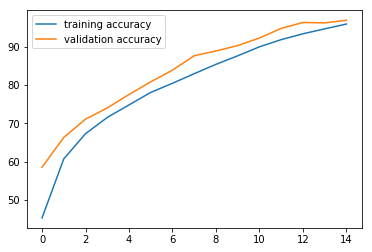

In [50]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

From the smaller kernel size and the deeper network, it doesn't seem like the accuracy is that much better. But there's not really a risk of overfitting.

## Lesson 3: Data Augmentation

Transform data to augment and add new data to the data set. Taking existing dataset and transform/alter the image in useful ways (rotation, zoom in, etc.). It allows the model to look at each image from a variety of different perspectives. By increasing amount of relevant data, it prevents overfitting and prevents the model from learning irrelevant patterns. 

The variety of transformations are on pytorch documentation. We'll put the transforms section. 

In [17]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5), (0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
def im_convert(tensor):
    #cannot convert cuda tensor to numpy. need cpa
    #so if using cuda use:
    # image = tensor.cpu().clone().detach().numpy()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [19]:
#making a classes collection type
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

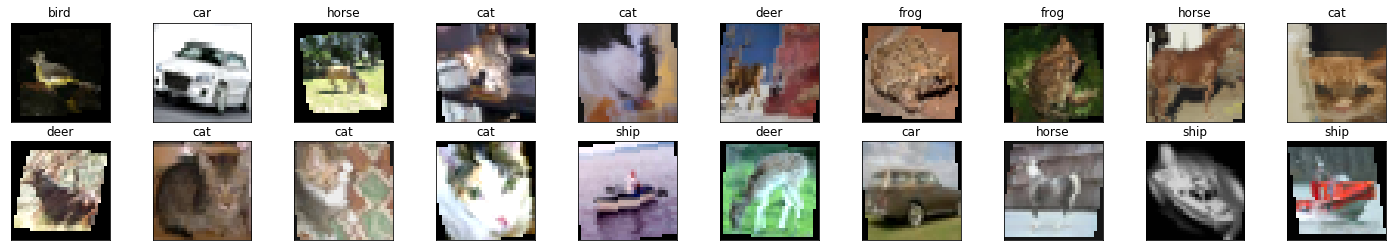

In [20]:
dataiter = iter(training_loader)
images, labels = dataiter.next() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

Using the learning rate of 0.001. 3 convolutional layers. and 3x3 kernel with padding

In [21]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        #define a convolutional layer
        #depth of conv1 is assigned as 16, doubling the layer gives 32
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)  # change kernel from 5 to 3 and added padding here to max edge feature extraction
        #doubling the conv1 (16) gives 32
        #this means the depth of the output is consistently increased going from one layer to the next
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        #deeper the layers, the more the network will extract more features
        
        #adding another convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        #define the fully connected layers
        self.fc1 = nn.Linear(4*4*64, 500) 
        self.fc2 = nn.Linear(500, 10) #output because 10 classes
    
    #define the pooling and activation functions
    def forward(self, x):
        x = F.relu(self.conv1(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        #second conv layer
        x = F.relu(self.conv2(x))
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        
        #applying the relu function to the 3rd layer! 
        #third conv layer
        x = F.relu(self.conv3(x)) #added depth will help extract more features effectively and improve accuracy. 
        #pooling layer
        x = F.max_pool2d(x, 2, 2)
        
        #reshape x, need to flatten so it can go into FC layer
        x = x.view(-1, 4*4*64) #THIS DEPENDS ON KERNEL SIZE...DOUBLE CHECK THIS. 
        #attach relu to first FC layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x) #no activation funciton here because going to use nn Cross entropy loss
        return x 

In [22]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 

In [24]:
#specifiy number of epochs
epochs = 15
#want to analyze loss after each epoch so need to graph
running_loss_history = []
running_corrects_history = [] #store accruacy at each epoch

##validation part
val_running_loss_history = []
val_running_corrects_history = []

#iterate through each epoch
for e in range(epochs):
    #need to go through each training batch provided by training loader
    running_loss = 0.0
    running_corrects = 0.0
    
    ##after training, we iterate through validation set to test our data
    #measure performance to check for overfitting 
    ##validation
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs) #call the forward function to get raw final score
        #output is compared to actual labels
        loss = criterion(outputs, labels) #compare and determine error based on cross entropy criterion
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) #first value is max score that was made by the model
        running_loss += loss.item() #append the current loss at the batch iteration to the loss list
        #want to compare the prediction to the actual label to see how many got correct
        #second value will be top predictions
        running_corrects += torch.sum(preds == labels.data) #every element of both tensors, compare the prediction to the actual class label
        #if comparision matches, then will place a value of one
    
    
    else:
        with torch.no_grad(): #set all requires grad flags to be false
        ##validation
            for val_inputs, val_labels in validation_loader: 
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                #make predictions and calculate loss for validation
                val_outputs = model(val_inputs)
                
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
        epoch_loss = running_loss/len(training_loader) #get the average loss at the epoch
        epoch_acc = running_corrects.float()/ len(training_loader) #average accuracy at that epoch
        #now append
        running_loss_history.append(epoch_loss) #observe decrease in loss at every epoch
        running_corrects_history.append(epoch_acc)
        
        ##same for validation
        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ len(validation_loader) 
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch :', (e+1)) #because epoch starts at 0
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6133, acc 40.9380
validation loss: 1.3451, validation acc 51.5900
epoch : 2
training loss: 1.3019, acc 53.4460
validation loss: 1.1162, validation acc 60.8000
epoch : 3
training loss: 1.1483, acc 59.3500
validation loss: 1.1011, validation acc 61.5300
epoch : 4
training loss: 1.0511, acc 62.7560
validation loss: 0.9265, validation acc 67.3700
epoch : 5
training loss: 0.9690, acc 65.7680
validation loss: 0.8618, validation acc 69.0100
epoch : 6
training loss: 0.9166, acc 67.4000
validation loss: 0.8290, validation acc 71.2200
epoch : 7
training loss: 0.8740, acc 69.3680
validation loss: 0.8095, validation acc 71.5700
epoch : 8
training loss: 0.8365, acc 70.8160
validation loss: 0.7792, validation acc 72.6000
epoch : 9
training loss: 0.8061, acc 71.4640
validation loss: 0.7820, validation acc 72.4400
epoch : 10
training loss: 0.7783, acc 72.6120
validation loss: 0.7246, validation acc 74.9600
epoch : 11
training loss: 0.7523, acc 73.5060
validation loss: 0.7031

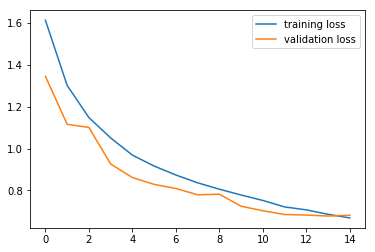

In [25]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

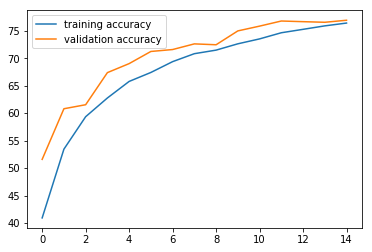

In [26]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

Here we see definitely over fitting! 

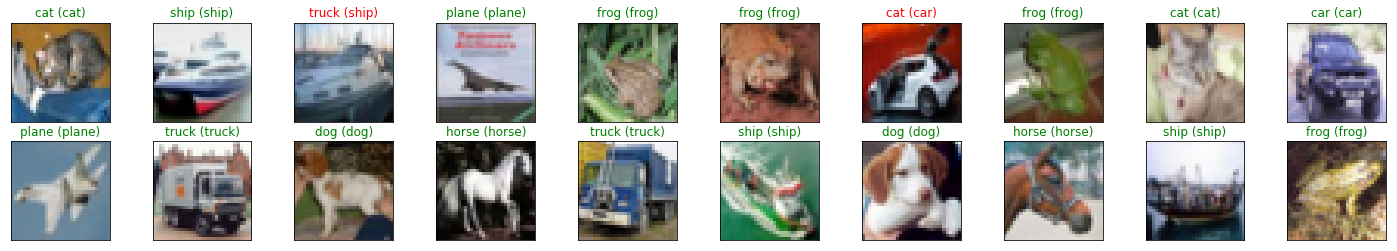

In [27]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
